In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [0]:
!pip install kaggle --upgrade -q

In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import zipfile

import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm_notebook as tq
from PIL import Image

In [0]:
from itertools import groupby
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
os.environ['KAGGLE_USERNAME']=""
os.environ['KAGGLE_KEY']=""

In [0]:
!pwd

/kaggle/working


In [0]:
!ls ../input

severstal-steel-defect-detection


In [0]:
# modifying below to add severstal-steel-defect-detection
#input_dir = "../input/"
#train_img_dir = "../input/train_images/"
input_dir = "../input/severstal-steel-defect-detection/"
train_img_dir = '../input/severstal-steel-defect-detection/train_images/'



In [0]:
!ls ../input/severstal-steel-defect-detection/

sample_submission.csv  test_images  train.csv  train_images


In [0]:
# NOTE THAT train.csv provides segments for defects - so will only contain images with defects - see below
train_df = pd.read_csv(input_dir + "train.csv")
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [0]:
train_df.shape

(7095, 3)

In [0]:
train_df['ClassId'] = train_df['ClassId'].astype(int)
train_df = train_df.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
train_df['defects'] = train_df.count(axis=1)
train_df.head(10)

ClassId,1,2,3,4,defects
ImageId,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN,1
000f6bf48.jpg,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
0014fce06.jpg,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN,1
0025bde0c.jpg,NaN,NaN,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,315139 8 315395 15 315651 16 315906 17 316162 ...,2
002af848d.jpg,NaN,NaN,NaN,290800 6 291055 13 291311 15 291566 18 291822 ...,1
002fc4e19.jpg,146021 3 146275 10 146529 40 146783 46 147038 ...,145658 7 145901 20 146144 33 146386 47 146629 ...,NaN,NaN,2
0030401a5.jpg,NaN,NaN,NaN,186833 1 187089 3 187344 6 187600 7 187855 10 ...,1


In [0]:
# Find number of defects in each class
import numpy as np
import math

no_defect = np.sum(train_df['defects'] == 0)
one_defect = np.sum(train_df['defects'] == 1)
two_defect = np.sum(train_df['defects'] == 2)
three_defect = np.sum(train_df['defects'] == 3)
four_defect = np.sum(train_df['defects'] == 4)
defects_sum = len(train_df) - no_defect

print("no defect imgs \t:", no_defect)
print("one defect imgs \t:", one_defect)
print("two defect imgs \t:", two_defect)
print("three defect imgs \t:", three_defect)
print("four defect imgs \t:", four_defect)
print("defective imgs total \t:", one_defect + two_defect + three_defect + four_defect)
print("check defective imgs total \t:", defects_sum)
print("Length of train_df \t:", len(train_df))

no defect imgs 	: 0
one defect imgs 	: 6239
two defect imgs 	: 425
three defect imgs 	: 2
four defect imgs 	: 0
defective imgs total 	: 6666
check defective imgs total 	: 6666
Length of train_df 	: 6666


In [0]:
!pwd
# !ls ../input/severstal-steel-defect-detection/train-images

/kaggle/working


In [0]:
PATH = '../input/severstal-steel-defect-detection/'
TRAIN = '../input/severstal-steel-defect-detection/train_images/'
TEST = '../input/severstal-steel-defect-detection/test_images/'
path_working = Path('/kaggle/working')

In [0]:
!ls {TRAIN}

0002cc93b.jpg  3294c9bd1.jpg  662e5a5ee.jpg  99743b154.jpg  cc21f2f40.jpg
00031f466.jpg  329de935b.jpg  663248e1d.jpg  99852bd26.jpg  cc2a3d558.jpg
000418bfc.jpg  32a201cd2.jpg  6634574cd.jpg  99855ae32.jpg  cc3a294d4.jpg
000789191.jpg  32a6666a3.jpg  663abe741.jpg  998a49fb9.jpg  cc3b99f17.jpg
0007a71bf.jpg  32add31cd.jpg  66480ece5.jpg  998d686d8.jpg  cc4f577af.jpg
000a4bcdd.jpg  32afab66f.jpg  664c8105a.jpg  99923d074.jpg  cc5401a6a.jpg
000f6bf48.jpg  32b45e155.jpg  66574a641.jpg  999263047.jpg  cc59639b2.jpg
0014fce06.jpg  32b47f255.jpg  665a8347a.jpg  999497bb8.jpg  cc5bae861.jpg
001982b08.jpg  32b55fcf1.jpg  6666f7f16.jpg  99972b00f.jpg  cc5ef39e3.jpg
001d1b355.jpg  32dca5f32.jpg  6668e50d0.jpg  99984eccf.jpg  cc5f6debe.jpg
001d3d093.jpg  32dfb96b8.jpg  666960b16.jpg  99a3eb6a2.jpg  cc61104ff.jpg
0025bde0c.jpg  32eca38d5.jpg  667f219fa.jpg  99a9163bc.jpg  cc69501eb.jpg
002af848d.jpg  32ed255a4.jpg  66849c8bd.jpg  99a941366.jpg  cc73c4765.jpg
002e73b3c.jpg  32efbaf94.jpg  6685aa0f

1e6d08dd9.jpg  51f9ccdd2.jpg  84beeb839.jpg  b778a2a3e.jpg  eb082ef3e.jpg
1e7415a4c.jpg  51fd0e994.jpg  84c34d791.jpg  b782bd738.jpg  eb0969906.jpg
1e742caeb.jpg  51ff1aef9.jpg  84cb84903.jpg  b78629be2.jpg  eb0c5c725.jpg
1e75373b2.jpg  5210ac609.jpg  84d0c1ee2.jpg  b7871011a.jpg  eb10d7ae4.jpg
1e7893a11.jpg  52122168a.jpg  84d1278e3.jpg  b78ea8d16.jpg  eb1195bcc.jpg
1e7a089c5.jpg  5213b418b.jpg  84d30fb77.jpg  b7982b7d8.jpg  eb18f69ed.jpg
1e7b96509.jpg  521632501.jpg  84dc30d02.jpg  b799d56cd.jpg  eb1f38f03.jpg
1e7c529a2.jpg  521f4df19.jpg  84df99a15.jpg  b79a0d30f.jpg  eb2008abd.jpg
1e893e86c.jpg  5226a20da.jpg  84e51db1c.jpg  b79c520bb.jpg  eb27105ee.jpg
1e896dda7.jpg  5227a284c.jpg  84eac92fc.jpg  b7a1d89ae.jpg  eb2b64947.jpg
1e954c608.jpg  5227eaed2.jpg  84edf7afb.jpg  b7a2b2275.jpg  eb2b76683.jpg
1e95fc3d7.jpg  522885da1.jpg  850058ea8.jpg  b7b29537e.jpg  eb38788df.jpg
1e963d7f6.jpg  5228ec6b5.jpg  8507771d9.jpg  b7b6fd4ed.jpg  eb3f5c9c8.jpg
1e979fb66.jpg  522ade1d3.jpg  85094416

In [0]:
print("Num of Train images \t:", len(os.listdir(TRAIN)))
print("Num of Test images \t:", len(os.listdir(TEST)))

Num of Train images 	: 12568
Num of Test images 	: 5506


In [0]:
# To find number of defects of each class 
# subtract nans in each col from total length of df

# Note that there are ALSO 5902 0 defect or NO DEFECT images 
class_defects = len(train_df) - train_df.isnull().sum()
class_defects[:4]

ClassId
1     897
2     247
3    5150
4     801
dtype: int64

In [0]:
file1_dup = Path(TRAIN).ls()[0]

In [0]:
file1_dup

PosixPath('../input/severstal-steel-defect-detection/train_images/74c8a2d5a.jpg')

In [0]:
file1 = (next(Path(TRAIN).iterdir()))

In [0]:
# notice that this is same so another way to access
file1

PosixPath('../input/severstal-steel-defect-detection/train_images/74c8a2d5a.jpg')

In [0]:
image1 = PIL.Image.open(file1)

In [0]:
image1.size

(1600, 256)

In [0]:
# Check sizes of all images
from collections import defaultdict

train_size = defaultdict(int)
test_size = defaultdict(int)

for fPath in Path(TRAIN).iterdir():
    img = PIL.Image.open(fPath)
    train_size[img.size] += 1

for fPath in Path(TEST).iterdir():
    img = PIL.Image.open(fPath)
    test_size[img.size] += 1
    
print("train image sizes \t:", train_size)
print()
print("test image sizes \t:", test_size)

train image sizes 	: defaultdict(<class 'int'>, {(1600, 256): 12568})

test image sizes 	: defaultdict(<class 'int'>, {(1600, 256): 5506})


**VISUALIZE**

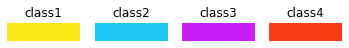

In [0]:
# Function that defines and shows four different colors to be used
# for the four classes
#

palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250,60,20)]

fig, ax = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((10, 40, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class{}".format(i+1))

plt.show()

In [0]:
# Function converting mask into rgba colors for each of the four classes
# append to the rgba_list. The idx is the index indicating class
def mask2rgba(mask):
    rgba_list = []
    for idx in range(4):    # idx: class id
        rgba = cv2.cvtColor(mask[:, :, idx], cv2.COLOR_GRAY2RGBA)
        rgba[:, :, :3] = rgba[:, :, :3] /255 * palet[idx]
        rgba_list.append(rgba)
    return rgba_list

In [0]:
# 
# Function that parses row by row to generate the masks for each row ie masks for each image
# for all the defect classes present in that image.
#
# notice that input is row_id and outputs are filename (equivalent to ImageId) and masks
# For order = 'F' refer to the fact that image is RLE coded going down the rows of the first col
# then col by col. 
# The numpy reshape link with order='F' option is at 
# https://numpy.org/doc/1.18/reference/generated/numpy.reshape.html
#
def make_mask(row_id):
    fname = train_df.iloc[row_id].name

    labels = train_df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [0]:
# Function to show the mask images
# TBD contour - seems to be draw countour using polylines
# vs just make a block with color of palet for the mask
#
def show_mask_image(row_id, contour = True):
    name, mask = make_mask(row_id)
    #img = cv2.imread(os.path.join(DIRtrain, name))
    img = cv2.imread(os.path.join(TRAIN, name))

    if contour:
        for ch in range(4):
            contours, _ = cv2.findContours(mask[:, :, ch],
                            cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                cv2.polylines(img, contours[i], True, palet[ch], 2)
    else:
        for ch in range(4):
            img[mask[:,:,ch]==255] = palet[ch]
        
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title(name)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [0]:
# classify defects
# Note that this can include MORE than just that class ie idx_class_1 will have the first class
# BUT could also contain other classes since it only checks that it has class 1 for sure.
idx_class_1 = list(filter(lambda x:not pd.isna(train_df.iloc[x, 0]), range(len(train_df))))
idx_class_2 = list(filter(lambda x:not pd.isna(train_df.iloc[x, 1]), range(len(train_df))))
idx_class_3 = list(filter(lambda x:not pd.isna(train_df.iloc[x, 2]), range(len(train_df))))
idx_class_4 = list(filter(lambda x:not pd.isna(train_df.iloc[x, 3]), range(len(train_df))))

# Number of defect classes
# Notice that idx_no_defect is NOT present in train_csv hence commented out

#idx_no_defect = list(filter(lambda x:train_df.iloc[x, 4] == 0, range(len(train_df))))
idx_1_defect = list(filter(lambda x:train_df.iloc[x, 4] == 1, range(len(train_df))))
idx_multi_defect = list(filter(lambda x:train_df.iloc[x, 4] >= 2, range(len(train_df))))

In [0]:
# Cannot plot no defect sample coz no images in train.csv have 0 defects
# Hence commented out

#for idx in idx_no_defect[:3]:
#    show_mask_image(idx)

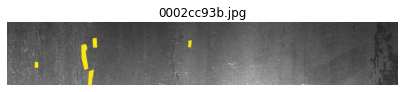

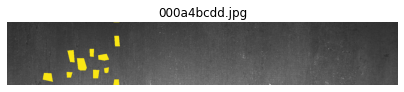

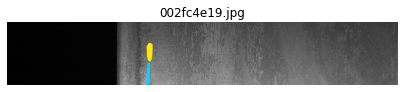

In [0]:
# Plot class_1 defect sample color is Yellow
# Plot 3 samples 
for idx in idx_class_1[:3]:
    show_mask_image(idx, contour=False)

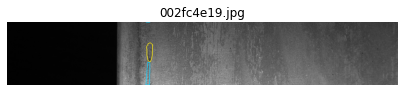

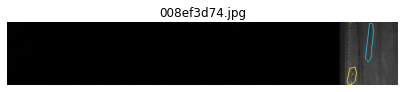

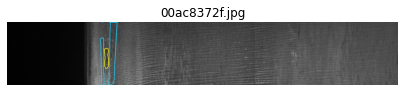

In [0]:
# class_2 defect sample (lightblue)
for idx in idx_class_2[:3]:
    show_mask_image(idx, contour=True)

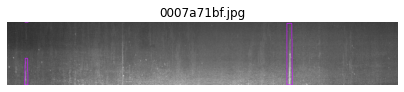

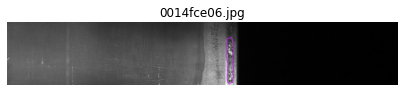

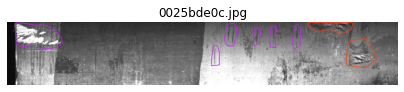

In [0]:
# class_3 defect sample (purple)
for idx in idx_class_3[:3]:
    show_mask_image(idx, contour=True)

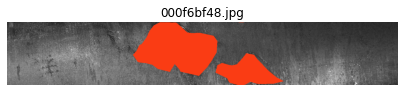

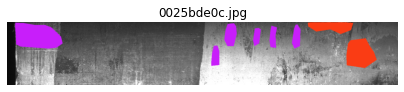

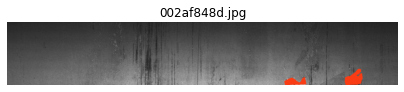

In [0]:
# class_4 defect sample (RED)
for idx in idx_class_4[:3]:
    show_mask_image(idx, contour=False)

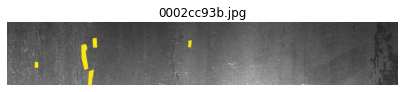

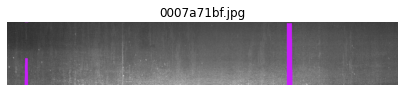

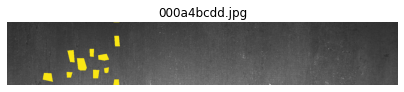

In [0]:
# Show single class defects only 
for idx in idx_1_defect[:3]:
    show_mask_image(idx, contour=False)

In [0]:
# Show multi-class defects only 
for idx in idx_multi_defect[:3]:
    show_mask_image(idx, contour=False)

NameError: name 'idx_class_multi' is not defined